In [1]:
import numpy as np
from scipy.integrate import odeint
import torch
import myplot
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import praktikum
import torch.nn.functional as F
from itertools import chain
device=myplot.try_gpu()

In [70]:
# Define the SIRDN system
def ode(y, t, gamma):
    S, I, R, D, N = y
    mu = 0.078 * np.exp(t / 150 * np.log(0.005 / 0.078))
    beta = 0.3 * np.exp(t/ 150 * np.log(0.5))
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    dNdt = -mu * I
    return [dSdt, dIdt, dRdt, dDdt, dNdt]

beta=lambda x:0.3*np.exp(x / T * np.log(0.5))
mu=lambda x:0.078*np.exp(x / T * np.log(0.005/0.078))

# Initial values
y0 = torch.tensor([999000., 1000., 0., 0., 1000000.])

# Total time
T=150
step=1
t =torch.arange(0.,T,step)
real=beta(t),mu(t)
gamma = 0.1

# Generate the data and corresponding derivatives
simulation = torch.tensor(odeint(ode, y0, t, args=(gamma,)))
dSdt, dIdt, dRdt, dDdt, dNdt = ode(simulation.T, t, gamma)
derivatives=torch.cat((dSdt.reshape(-1,1),dIdt.reshape(-1,1),dRdt.reshape(-1,1),dDdt.reshape(-1,1),dNdt.reshape(-1,1)),dim=1)

# length of each input time step
lag = 1
features = torch.zeros((int(T/step) - lag+1, lag))
for i in range(lag):
    features[:, i] = t[i: int(T/step) - lag + i+1]

In [48]:
# Some plot functions
def woplot(data, t, type='--', label=None,display_R=False):
    if label is None:
        label = ['S', 'I', 'R', 'D', 'N']
    else:
        label = ['dS', 'dI', 'dR', 'dD', 'dN']
    plt.plot(t, data[:, 0], label=label[0],linestyle=type)
    plt.plot(t, data[:, 1], label=label[1],linestyle=type)
    if display_R:
        plt.plot(t, data[:, 2], label=label[2],linestyle=type)
    plt.plot(t, data[:, 3], label=label[3],linestyle=type)
    plt.plot(t, data[:, 4], label=label[4],linestyle=type)
    plt.legend()
    plt.show()

def getbypre(data,beta,mu,lag):
    # get the derivatives
    dS=-torch.tensor(beta).squeeze()*data[:,lag]*data[:,lag+1]/data[:,lag+4]
    dI=-dS-(0.1+torch.tensor(mu).squeeze())*data[:,lag+1]
    dR=0.1*data[:,lag+1]
    dD=torch.tensor(mu).squeeze()*data[:,lag+1]
    dN=-dD
    return torch.cat((dS.unsqueeze(1), dI.unsqueeze(1), dR.unsqueeze(1), dD.unsqueeze(1), dN.unsqueeze(1)), dim=1)

def compare_woplot(true_data, pre_data, t, type='--', label=None, display_R=False):
    # T means true or simulated data P means predicated data
    if label is None:
        label = ['TS', 'TI', 'TR', 'TD', 'TN']
    else:
        label = ['TdS', 'TdI', 'TdR', 'TdD', 'TdN']
    plt.plot(t, true_data[:, 0], label=label[0], linestyle='solid')
    plt.plot(t, true_data[:, 1], label=label[1], linestyle='solid')
    if display_R:
        plt.plot(t, true_data[:, 2], label=label[2], linestyle='solid')
    plt.plot(t, true_data[:, 3], label=label[3], linestyle='solid')
    plt.plot(t, true_data[:, 4], label=label[4], linestyle='solid')

    if label == ['TS', 'TI', 'TR', 'TD', 'TN']:
        label = ['PS', 'PI', 'PR', 'PD', 'PN']
    elif label == ['TdS', 'TdI', 'TdR', 'TdD', 'TdN']:
        label = ['PdS', 'PdI', 'PdR', 'PdD', 'PdN']
    plt.plot(t, pre_data[:, 0], label=label[0], linestyle=type)
    plt.plot(t, pre_data[:, 1], label=label[1], linestyle=type)
    if display_R:
        plt.plot(t, pre_data[:, 2], label=label[2], linestyle=type)
    plt.plot(t, pre_data[:, 3], label=label[3], linestyle=type)
    plt.plot(t, pre_data[:, 4], label=label[4], linestyle=type)

    plt.legend()
    plt.show()

def pre_para_ode(y, t, gamma, step):
    S, I, R, D, N = y
    beta = pre_beta[int(t/step)]
    mu = pre_mu[int(t/step)]
    dSdt = -beta * S * I / N
    dIdt = -dSdt - (gamma + mu) * I
    dRdt = gamma * I
    dDdt = mu * I
    dNdt = -dDdt
    return [dSdt, dIdt, dRdt, dDdt, dNdt]

def pre_ode(beta, mu, T, lag,simulation=None, compare=False, step=1):
    y0 = torch.tensor([999000., 1000., 0., 0., 1000000.])
    gamma = 0.1
    # since we have the beta and mu already(but in the array)
    global pre_beta, pre_mu
    pre_beta = beta
    pre_mu = mu
    t = torch.arange(0., T, step)
    t=t[:-lag]
    if compare:
        compare_woplot(simulation[:-lag], odeint(pre_para_ode, y0, t, args=(gamma,step)), t)
    else:
        woplot(odeint(pre_para_ode, y0, t, args=(gamma,)), t, '--')

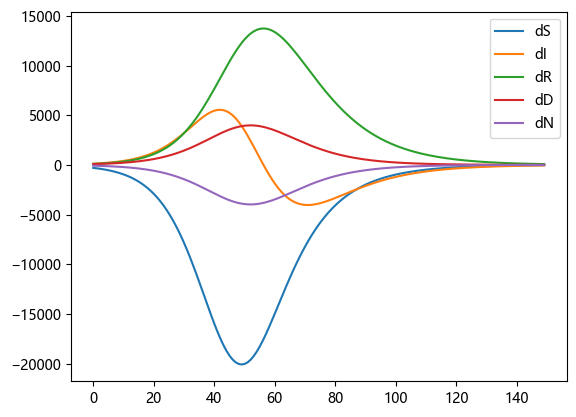

In [110]:
woplot(derivatives,t,label=1,display_R=True,type='solid')

In [91]:
def simple_with_time(data_with_time, lag, batch_size, train_ratio, isshuffle=False,  noise=False, reverse=False):
    # change the scale of the data
    data_with_time[:,lag:]=data_with_time[:,lag:]/1000
    # add noise
    if noise:
        data_with_time[:,1:] += 0.0005 * torch.randn(data_with_time[:,1:].shape)
    # reverse the data
    if reverse:
        data_with_time = torch.flip(data_with_time, [0])

    total_size = len(data_with_time)
    train_size = int(total_size * train_ratio)

    train_dataset = TensorDataset(
        data_with_time[:train_size, :lag+5].type(torch.float32),
        data_with_time[:train_size, lag+5:].type(torch.float32)
    )
    test_dataset = TensorDataset(
        data_with_time[train_size:, :lag+5].type(torch.float32),
        data_with_time[train_size:, lag+5:].type(torch.float32)
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=isshuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [92]:
# concat the time t and data
total=torch.cat((features,simulation[lag-1:,:],derivatives[lag-1:,:]),dim=1)
# get the train data and test data
train_data,test_data=simple_with_time(total,lag,20,0.7,isshuffle=False,noise=False,reverse=False)
c=0
for x,y in train_data:
    print(y)
    if c==2:
        break
    c+=1

tensor([[-0.2997,  0.1217,  0.1000,  0.0780, -0.0780],
        [-0.3368,  0.1374,  0.1129,  0.0865, -0.0865],
        [-0.3786,  0.1551,  0.1275,  0.0959, -0.0959],
        [-0.4254,  0.1750,  0.1440,  0.1063, -0.1063],
        [-0.4779,  0.1974,  0.1626,  0.1179, -0.1179],
        [-0.5369,  0.2226,  0.1836,  0.1307, -0.1307],
        [-0.6030,  0.2509,  0.2073,  0.1448, -0.1448],
        [-0.6770,  0.2826,  0.2339,  0.1605, -0.1605],
        [-0.7599,  0.3182,  0.2639,  0.1778, -0.1778],
        [-0.8527,  0.3581,  0.2977,  0.1969, -0.1969],
        [-0.9565,  0.4028,  0.3357,  0.2180, -0.2180],
        [-1.0724,  0.4527,  0.3784,  0.2413, -0.2413],
        [-1.2018,  0.5084,  0.4264,  0.2670, -0.2670],
        [-1.3461,  0.5705,  0.4803,  0.2953, -0.2953],
        [-1.5068,  0.6397,  0.5408,  0.3264, -0.3264],
        [-1.6856,  0.7165,  0.6085,  0.3606, -0.3606],
        [-1.8843,  0.8017,  0.6843,  0.3982, -0.3982],
        [-2.1047,  0.8961,  0.7692,  0.4394, -0.4394],
        [-

In [93]:
class ParameterNet(nn.Module):
    def __init__(self,lag):
        super(ParameterNet, self).__init__()
        self.lstm = nn.LSTM(input_size=lag, hidden_size=32, num_layers=1, batch_first=True)  #add lstm
        self.para = nn.Sequential(
            nn.Linear(32,20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20,1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x,_=self.lstm(x)
        return self.para(x)

In [94]:
class Net(nn.Module):
    def __init__(self,lag):
        super(Net, self).__init__()
        self.lag=lag
        self.beta=ParameterNet(lag)
        self.mu=ParameterNet(lag)

    def forward(self, x):
        lag=self.lag
        t=x[:,:lag]
        S=x[:,lag].reshape(-1,1)
        I=x[:,lag+1].reshape(-1,1)
        N=x[:,lag+4].reshape(-1,1)
        pre_beta=self.beta(t)
        pre_mu=self.mu(t)
        # based on the ODE system
        dS=-pre_beta*S*I/N
        dI=-dS-(pre_mu+0.1)*I
        dD=pre_mu*I
        return dS,dI,dD

In [95]:
net = Net(lag)
# initialize the network
def init_weights(m):
        if type(m)==nn.Linear:
            nn.init.kaiming_uniform_(m.weight) #since use the relu
net.apply(init_weights)
criterion = nn.MSELoss()

In [96]:
def train(net,device,train,test,optimizer,criterion,epoch):
    net.to(device)
    train_loss_list = []  # save the train loss
    test_loss_list = []  # save the test loss
    optimizer_beta=optimizer[0]
    optimizer_mu=optimizer[1]

    for i in range(epoch):
        net.train()
        train_loss = 0
        for X_train,y_train in train:
            X_train,y_train=X_train.to(device),y_train.to(device)
            p=net(X_train)
            optimizer_beta.zero_grad()
            loss1=criterion(p[0],y_train[:,0:1])
            loss1.backward(retain_graph=True)
            optimizer_beta.step()

            optimizer_mu.zero_grad()
            loss2=criterion(p[2],y_train[:,3:4])
            loss2.backward()
            optimizer_mu.step()

            train_loss += loss1.item()
            train_loss += loss2.item()

        net.eval()
        test_loss = 0
        with torch.no_grad():
            for X_test, y_test in test:
                X_test, y_test = X_test.to(device), y_test.to(device)
                out = net(X_test)
                loss1=criterion(out[0],y_test[:,0:1])
                loss2=criterion(out[2],y_test[:,3:4])
                test_loss += loss1.item()
                test_loss += loss2.item()

        # calculate average loss
        avg_train_loss = train_loss / len(train)
        avg_test_loss = test_loss / len(test)

        train_loss_list.append(avg_train_loss)
        test_loss_list.append(avg_test_loss)

        if i%100==0:
            print('Epoch:', i, 'Train loss:', avg_train_loss, 'Test loss:', avg_test_loss)

    plt.plot(train_loss_list,label='train')
    plt.plot(test_loss_list,label='test')
    plt.legend()
    return train_loss_list, test_loss_list

Epoch: 0 Train loss: 0.0011259656307629484 Test loss: 0.00022054670989746228
Epoch: 100 Train loss: 0.00013873641096514197 Test loss: 0.00016559856521780603
Epoch: 200 Train loss: 9.510310673969495e-05 Test loss: 0.00015957683475183634
Epoch: 300 Train loss: 0.012252472468882539 Test loss: 0.000125341235010031
Epoch: 400 Train loss: 0.0033485761035384107 Test loss: 0.00021617298261844553
Epoch: 500 Train loss: 0.00010650749457378576 Test loss: 0.00015883731369588835
Epoch: 600 Train loss: 9.713363467274878e-05 Test loss: 0.0001458357170728656
Epoch: 700 Train loss: 8.431908091210971e-05 Test loss: 0.00014066873457826054
Epoch: 800 Train loss: 8.414510027895024e-05 Test loss: 0.0001384588091847642
Epoch: 900 Train loss: 0.019383347668413837 Test loss: 0.000155586928788883


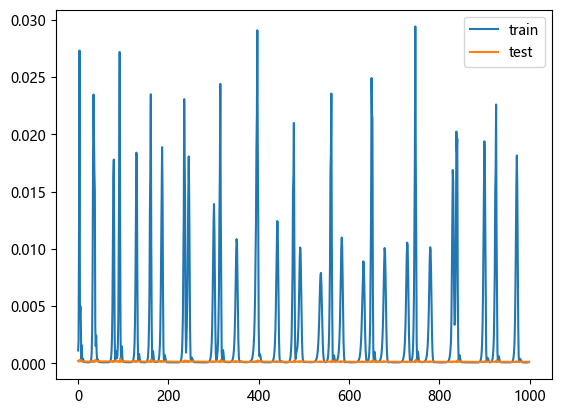

In [103]:
optimizer=[torch.optim.Adam(net.beta.parameters(),lr=0.0005,weight_decay=1e-6),
           torch.optim.Adam(net.mu.parameters(),lr=0.0005,weight_decay=1e-6)]
train_loss_list, test_loss_list=train(net,device,train_data,test_data,optimizer,criterion,epoch=1000)

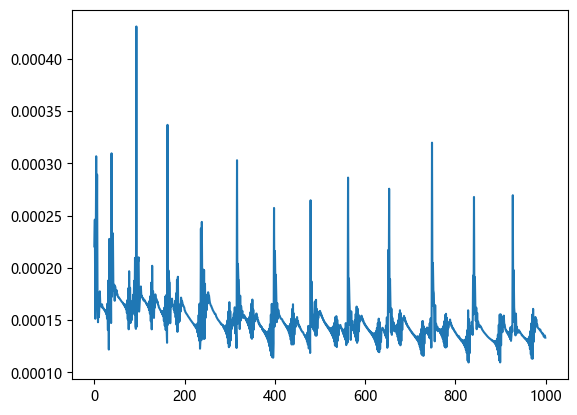

In [104]:
plt.plot(test_loss_list)

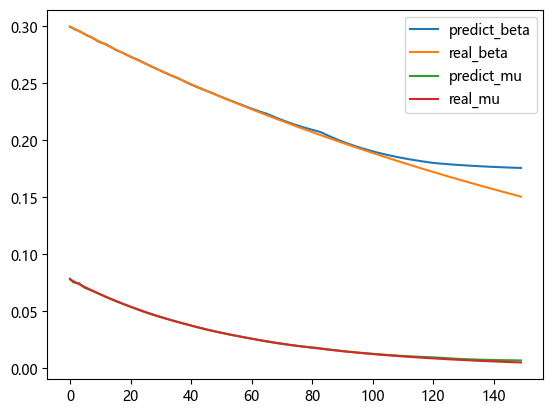

In [108]:
net.to('cpu')
pre_mu=net.mu(features).detach().numpy()
pre_beta=net.beta(features).detach().numpy()
plt.plot(pre_beta,label='predict_beta')
plt.plot(real[0],label='real_beta')
plt.plot(pre_mu,label='predict_mu')
plt.plot(real[1],label='real_mu')
plt.legend()

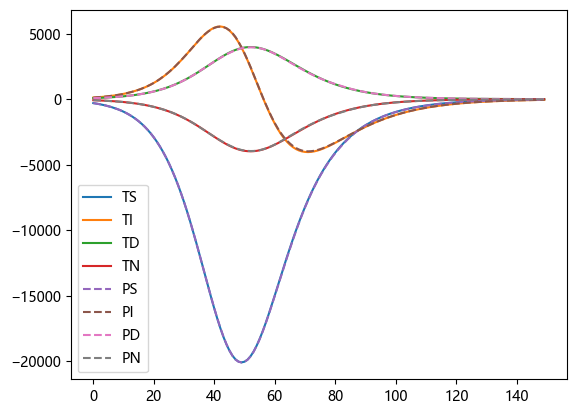

In [106]:
result = getbypre(total,pre_beta,pre_mu,lag)
compare_woplot(derivatives[lag-1:],result*1000,t[lag-1:])

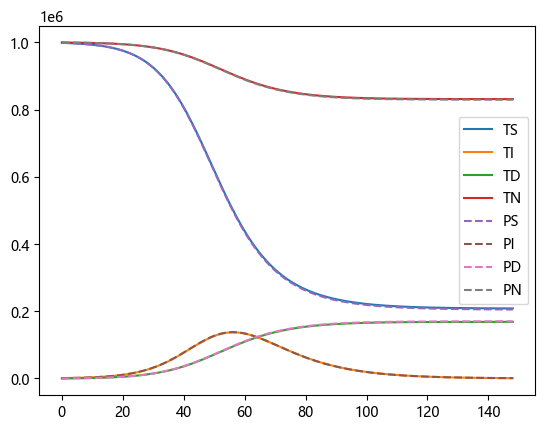

In [112]:
pre_ode(pre_beta, pre_mu, T, lag, simulation, compare=True, step=step)